# Classification Toolbox - Sentinel-3 Example
## Create training data, create clusters, time series patterns

The classification toolbox provides three main methods; production of a training dataset, generation of a model which defines the optimum number of optical water types and 'fuzziness'

Fuzzy clustering optical water type (OWT) models are fitted to a subset of the total data timeseries in a phase called training. In a second step, the fitted model is then applied to new data. Table of cluster centers and plots of model selection peformance are provided, together with membership histograms (ideally bimodal), example geographic membership distrubtion on a single day, membership occurrence rates over time and dominant OWT maps over whole time series as well as monthly.



## 1. Creation of Training Dataset
### 1.1 Libraries & variables setup

In [52]:
from datetime import datetime
import glob
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import random
import rasterio
from statsmodels.graphics.gofplots import qqplot
import subsample_OLCI as subsample
import tempfile
import warnings
import xarray as xr

In [22]:
# run_date is added to exported filenames for book keeping
run_date = datetime.strftime(datetime.now(), "%Y%m%d")

# The ROI to process - one of:
# "Curonian_Lagoon","Danube_Delta","German_Bight","Tagus_Estuary","Plymouth_Sound","Venice_Lagoon" 
region = "Curonian_Lagoon"

# The sampling method to use - one of:
# 'regular','random','stratified_random','weighted_random'
sampling_method = 'weighted_random'

features = ["Rw400_rep","Rw412_rep","Rw443_rep","Rw490_rep","Rw510_rep","Rw560_rep","Rw620_rep","Rw665_rep",
            "Rw674_rep","Rw681_rep","Rw709_rep","Rw754_rep","Rw779_rep","Rw865_rep","Rw885_rep"]
# list used in first reporting 400, 412, 443, 490, 510, 560, 620, 665, 674, 681 and 709nm
# removed atm corr bands with predominantly negative Rw values
shore_dist = 20000
# in meters

This second set of variables match the regions full name with a shortened version of the name (`dirdict`); `winterdict` sets the months the exclude when creating the training data, mainly due to poor light conditions and/or poor coverage due to weather conditions. `tgooddict` specifies the index of the good example images to use

In [23]:
dirdict = {"Plymouth_Sound":"tamar", "Curonian_Lagoon":"curonian","Danube_Delta":"danube", 
           "Venice_Lagoon":"venice","Tagus_Estuary":"tagus", "German_Bight":"elbe"}
site = dirdict[region]

# defined using NOAA solcalc (https://gml.noaa.gov/grad/solcalc/) and max incident light level <30°
winterdict = {"Plymouth_Sound":[2,11], "Curonian_Lagoon":[2,10],"Danube_Delta":[1,11], 
           "Venice_Lagoon":[0,12],"Tagus_Estuary":[0,12], "German_Bight":[1,11]}
# 'tamar':[2,11],'curonian':[2,10],'danube':[1,11],'venice':[0,12],'tagus':[0,12],'elbe':[1,11]
winter_months = winterdict[region]

# dates with very low cloud cover, good example image
tgooddict = {"Plymouth_Sound":1273, "Curonian_Lagoon":1398,"Danube_Delta":1263, 
           "Venice_Lagoon":1210,"Tagus_Estuary":1092, "German_Bight":1600}
time_good = tgooddict[region]

### 2. Select subsampling routine, check coverage, and create training data

We used OLCI 300m data (sensors A and B) from Apr. 2016 to Mar. 2021 to build the training dataset. Data were atmospherically corrected with POLYMER, following the CALIMNOS lakes processing chain. Specifics include:
-	Reflectances in Rw as opposed to Rrs
-	Bands used for clustering: 400, 412, 443, 490, 510, 560, 620, 665, 674, 681, 709, 754, 779, 865, 885 nm
-	Winter month exclusion from training dataset (based on incident light level <30° calculated using NOAA solcalc): October-February


In [25]:
data_path = f'/data/datasets/Projects/CERTO/no-backup/olci_data/L3_com/v1.4.0/1D/300/{site}/*.nc'
dflist = glob.glob(data_path)
dflist.sort()
ds = xr.open_dataset(dflist[time_good])

ds = ds[features]
ds

<xarray.Dataset>
Dimensions:    (time: 1, lat: 377, lon: 345)
Coordinates:
  * lat        (lat) float64 55.73 55.73 55.73 55.72 ... 54.9 54.9 54.89 54.89
  * lon        (lon) float64 20.52 20.52 20.52 20.53 ... 21.28 21.28 21.28 21.29
  * time       (time) datetime64[ns] 2020-08-15T08:43:07.500000
Data variables: (12/15)
    Rw400_rep  (time, lat, lon) float32 ...
    Rw412_rep  (time, lat, lon) float32 ...
    Rw443_rep  (time, lat, lon) float32 ...
    Rw490_rep  (time, lat, lon) float32 ...
    Rw510_rep  (time, lat, lon) float32 ...
    Rw560_rep  (time, lat, lon) float32 ...
    ...         ...
    Rw681_rep  (time, lat, lon) float32 ...
    Rw709_rep  (time, lat, lon) float32 ...
    Rw754_rep  (time, lat, lon) float32 ...
    Rw779_rep  (time, lat, lon) float32 ...
    Rw865_rep  (time, lat, lon) float32 ...
    Rw885_rep  (time, lat, lon) float32 ...
Attributes: (12/27)
    Conventions:                CF-1.4
    TileSize:                   64:64
    product_type:               CF-1.4
    time_coverage_start:        15-AUG-2020 08:42:17.582150
    time_coverage_end:          15-AUG-2020 09:43:15.384441
    processor:                  Calimnos
    ...                         ...
    purpose:                    This product was produced for the EU H2020 MO...
    copyright:                  Plymouth Marine Laboratory
    resolution:                 300
    comment:                    
    processing_time:            2021-03-11T13:59:34.095129
    trackingID:                 f89d6393-1eca-42dd-a036-2b5250aa8000

### 1.3 Create sampling points 

In this example we use `weighted_random` where sampling locations are random but with greater weighting towards locations nearer the coast. This cell produces a dataset, `ds_sum`, that records a supposed land mask by recording only pixels where there are no data values for any given pixel within the entire time series

In [29]:
ds_init = xr.open_dataset(dflist[0])
ds_sum = ds_init[[x for x in ds_init.data_vars if x.startswith("Rw4")][0]] 
ds_sum = ds_sum.fillna(0)
ds_sum = ds_sum*0

for i in range(0,len(dflist)):
    temp = xr.open_dataset(dflist[i])[[x for x in ds_init.data_vars if x.startswith("Rw4")][0]] 
    ds_sum[0] += np.nan_to_num(temp[0])
#     print(pd.to_datetime(temp.time.item()))
    if i % 50 ==0:
        print(f'{100*np.round(i/len(dflist), 3)} % done (till date: {pd.to_datetime(temp.time.item())})')
    temp.close()

ds_init.close()

0.0 % done (till date: 2016-04-26 09:36:33.750000128)
3.1 % done (till date: 2016-06-21 08:45:56.249999872)
6.2 % done (till date: 2016-08-17 09:08:26.249999872)
9.4 % done (till date: 2016-10-13 09:30:56.249999872)
12.5 % done (till date: 2016-12-08 08:37:30)
15.6 % done (till date: 2017-02-03 09:00:00)
18.7 % done (till date: 2017-03-31 09:47:48.750000128)
21.8 % done (till date: 2017-05-26 08:57:11.249999872)
24.9 % done (till date: 2017-07-21 09:45:00)
28.1 % done (till date: 2017-09-15 08:54:22.500000)
31.2 % done (till date: 2017-11-11 09:16:52.500000)
34.300000000000004 % done (till date: 2018-01-07 09:36:33.750000128)
37.4 % done (till date: 2018-03-04 08:45:56.249999872)
40.5 % done (till date: 2018-04-30 09:08:26.249999872)
43.6 % done (till date: 2018-06-26 09:30:56.249999872)
46.800000000000004 % done (till date: 2018-08-23 09:25:18.750000128)
49.9 % done (till date: 2018-10-18 08:34:41.249999872)
53.0 % done (till date: 2018-12-13 09:22:30)
56.10000000000001 % done (till d

In [30]:
# remove zero buffer as needed, watch for edge error in distance plots below

if site == 'curonian':
    ds_sum = xr.where(ds_sum.lat == float(ds_sum.lat.values.max()), ds_sum+1., ds_sum)
    ds_sum = xr.where(ds_sum.lon == float(ds_sum.lon.values.min()), ds_sum+1., ds_sum)
    ds_sum = ds_sum.T
    ds_sum = ds_sum.rename({'lon':'x', 'lat':'y'})

if site == 'tagus':
    ds_sum = ds_sum.isel(lon = slice(1,-1))
    ds_sum = ds_sum.isel(lat = slice(1,-1))

if site == 'tamar':
    ds_sum = ds_sum.isel(lon = slice(0,-1))
    

The resulting dataset is saved to a temp file location so that it can be accessed by gdal

In [31]:
temp_dir = tempfile.mkdtemp(prefix="temp_", dir=os.getcwd())
ds_sum.rio.write_crs("epsg:4326", inplace=True)
output_tiff = temp_dir + f'/{site}_summed.tif'
ds_sum.rio.to_raster(output_tiff)

Then saved the proximity file:

In [32]:
output_proximity = temp_dir + f'/{site}_proximity.tif'
!gdal_proximity.py -distunits PIXEL -values 0 -use_input_nodata YES -ot UInt16 $output_tiff $output_proximity

0...10...20...30...40...50...60...70...80...90...100 - done.


Transform distances into percentages for weighting

In [33]:
ds_prox = xr.open_rasterio(output_proximity)
d = ds_prox.where(ds_prox != 0)
d = d.where(d<66) # (66*300m is 20km)
# scale to percent and invert distances
d = -d/d.max()+1 
# set "offshore" weights 
d = d.where(d>0.1)
d = d.fillna(0.1)
# mask land values (nan in ds_prox), this is purely for visualization
mask = d.where(np.isnan(ds_prox))
mask = mask.fillna(2)
d = d.where(mask == 2)

/tmp/ipykernel_117564/1056582937.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_prox = xr.open_rasterio(output_proximity)


Produce a plot to demonstrate the distribution of sampling points for a single day

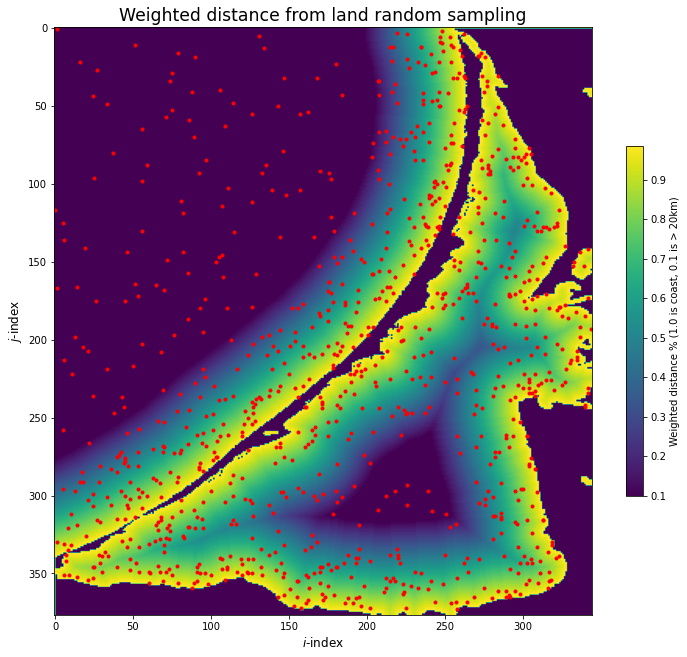

In [37]:
distances = np.clip(300.*ds_prox, 0, shore_dist) #300m per pixel and we want to have uniform sampling beyond 20km

rev_distances = ((shore_dist-(1*distances))/shore_dist)
capped_rev_distances = np.clip(rev_distances, 0.1, 0.99)

capped_masked_rev_distances_weightings = np.where(distances==0, distances, capped_rev_distances)
capped_masked_rev_distances_weightings = np.nan_to_num(capped_masked_rev_distances_weightings)
distances = distances.fillna(0)

flat_indices = np.arange(capped_masked_rev_distances_weightings.squeeze().size)
flat_weightings = capped_masked_rev_distances_weightings.squeeze().flat
test = np.unravel_index(
    random.choices(
        flat_indices, 
        k=1000, 
        weights=flat_weightings
    ), 
    capped_masked_rev_distances_weightings.squeeze().shape
)

# indices = np.indices(capped_masked_rev_distances_weightings.squeeze().shape)
sample_x = test[1]
sample_y = test[0]

plt.figure(figsize=(10,10))
plt.imshow(d.squeeze())
plt.colorbar(shrink=0.5, label="Weighted distance % (1.0 is coast, 0.1 is > 20km)")
plt.tight_layout()
plt.title("Weighted distance from land random sampling", size='xx-large')
plt.xlabel("$\it{i}$-index", size='large'); plt.ylabel("$\it{j}$-index", size='large')
plt.scatter(sample_x, sample_y, c='r', marker=".")

For the first ten points identified in the plot above, produce a plot of the spectra

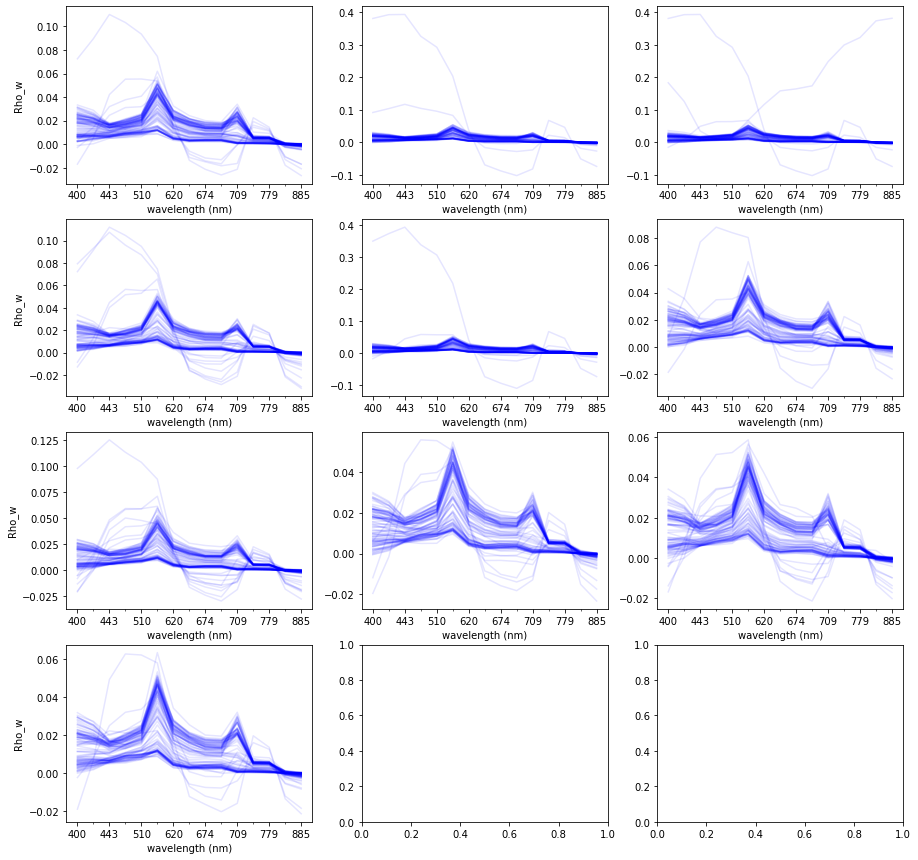

In [42]:
dd2 = ({key:ds[key].values[0,sample_y,sample_x] for key in ds.data_vars})

fig, axes_set=plt.subplots(4,3, figsize=(15,15))
for i in range(0,10):
    subset=pd.DataFrame.from_dict(dd2).values.T[:,i*100:(i*100)+100]
    axes_set.flatten()[i].plot([x[2:5] for x in features], subset, color='blue', alpha=0.1)
    axes_set.flatten()[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
    axes_set.flatten()[i].xaxis.set_minor_locator(plt.MultipleLocator(1))
    axes_set.flatten()[i].set_xlabel("wavelength (nm)")
    if i%3 == 0:
        axes_set.flatten()[i].set_ylabel("Rho_w")

### 1.4 Extract sampling point reflectance values 

Provided the test was successful, move on to pull out sampling points for the entire time series. 

**WARNING** this will take a long time and requires access to the full time series for the selected region

In [ ]:
# samples_full = subsample.subsample_OLCI_weightDist(
#     region=region,
#     months=winter_months,
#     weights=capped_masked_rev_distances_weightings,
#     indices=flat_indices,
#     n=100000
# )

Instead, for the purposes of demonstration, we can load a pre-prepared example:

In [45]:
samples_full = pd.read_csv(f'./curonian_S3_20220428_samplesFull.csv', sep=',')

Format the data rady for clustering:

In [47]:
samples = samples_full.loc[:,features]
# samples = samples_full.iloc[:,:-3]

col_names = {}
for n in range(0, len(samples.columns)):
    col_names[str(samples.columns[n])]=str(samples.columns[n].split("_")[0].split("Rw")[1])
samples = samples.rename(columns=col_names)

samples


400       412       443       490       510       560       620  \
0      0.023530  0.019728  0.012376  0.016155  0.022873  0.051459  0.034511   
1      0.006053  0.007931  0.010238  0.011270  0.012659  0.018133  0.005843   
2      0.004672  0.005603  0.006207  0.008114  0.009371  0.011813  0.004722   
3      0.007548  0.009193  0.007935  0.009069  0.009479  0.009612  0.002398   
4      0.001264  0.003000  0.005062  0.006881  0.007425  0.009551  0.003916   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.003940  0.006028  0.007448  0.009441  0.011318  0.014464  0.006071   
99996  0.000854  0.001821  0.003437  0.004304  0.005114  0.006025  0.002184   
99997  0.005037  0.005746  0.005939  0.008130  0.009653  0.017439  0.013926   
99998  0.018886  0.018937  0.012623  0.010667  0.011442  0.029726  0.009995   
99999  0.020202  0.016881  0.012270  0.013400  0.017730  0.036885  0.021047   

            665       674       681       709       754       779       865  \
0      0.027195  0.023258  0.024551  0.053249  0.013031  0.013948  0.002587   
1      0.002309  0.002061  0.001798  0.000616  0.002462  0.001592 -0.001277   
2      0.003105  0.003301  0.003310  0.001861  0.000865  0.000561  0.000089   
3      0.001188  0.001088  0.001114 -0.000141  0.001161  0.000563 -0.000547   
4      0.002481  0.003252  0.003481  0.001201  0.000772  0.000464  0.000064   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.003250  0.004000  0.003793  0.000593  0.001330  0.000824 -0.000055   
99996  0.002195  0.002293  0.002557 -0.000687  0.000360  0.000157  0.000124   
99997  0.008927  0.008401  0.008453  0.011343  0.003368  0.002804  0.000565   
99998  0.005361  0.003458  0.003858  0.026539  0.005565  0.004944 -0.003903   
99999  0.016419  0.013775  0.013766  0.027022  0.005039  0.005369  0.000091   

            885  
0      0.000257  
1     -0.002095  
2     -0.000125  
3     -0.001062  
4      0.000112  
...         ...  
99995 -0.000801  
99996  0.000234  
99997  0.000008  
99998 -0.005517  
99999 -0.001078  

[100000 rows x 15 columns]

At this point we have 10,000 random points, weighted by proximity to the coast; for each point (row), a reflectance value for each wavelength (column) is defined. 

Some the training data contains negative reflectances for particular bands, arising from errors in the atmospheric correction step. The decision has been made to retain as much of this information as possible in the cluster formation step so as to allow for exploration of clustering as a tool to identify such problematic pixels. A log transformation was chosen to reduce magnitude differences in similarly shaped spectra (plus helps fulfil the log-normal distribution expectation for reflectance data). However, log of a negative number is not usable for our purposes, thus a small additive shift was implemented prior to log transformation, chosen to balance reducing data loss with keeping shift as small as possible. Whilst we could simply remove the negative values, the effect would be a reduction in the size of the date. Instead, we shift the reflectance value by adding `0.015`. 

In this next step, we produce two series of plots; the first is a series of histograms showing the distribution of values along with a percentage of negative values at each wavelength. The second series shows the same after the shift of `0.015` has been applied

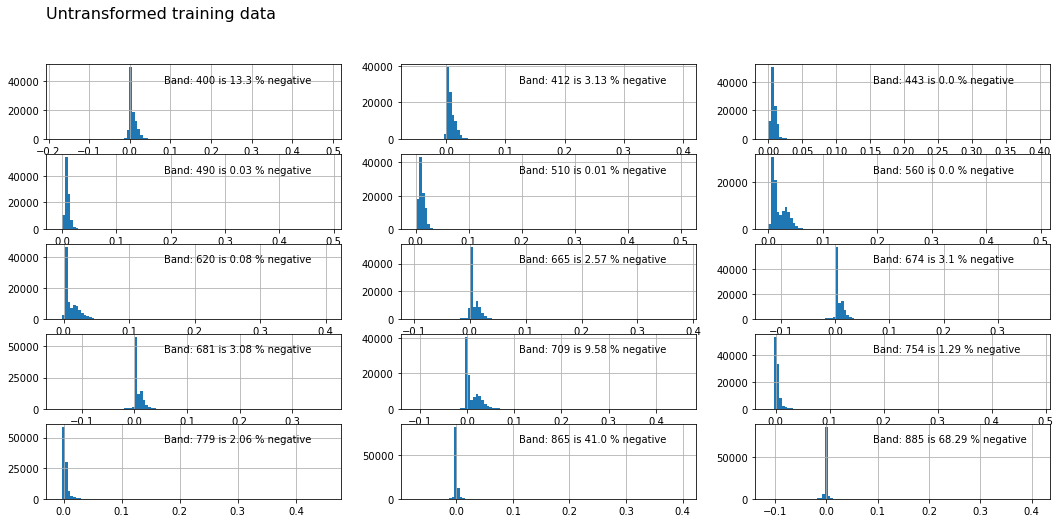

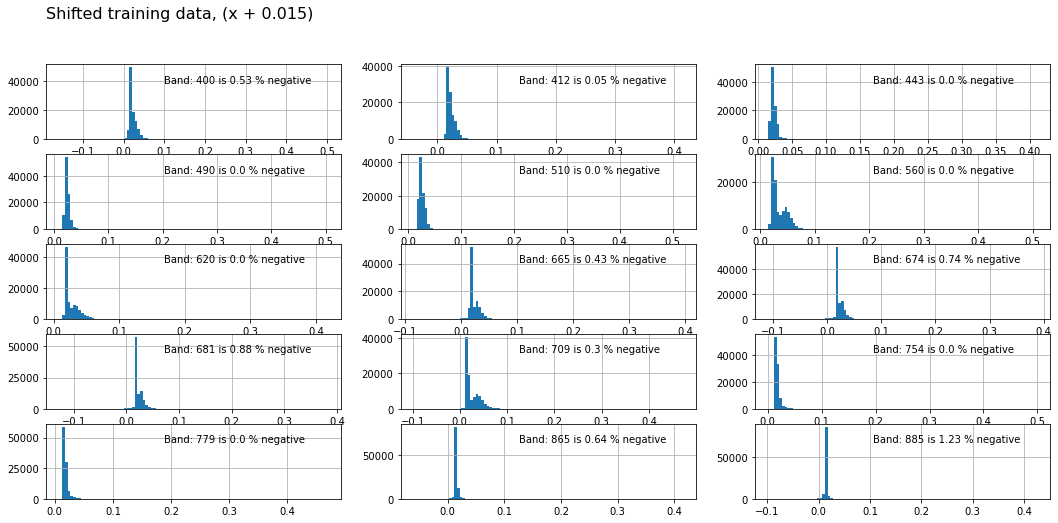

In [48]:
shift = 0.015

fig, axes=plt.subplots(int(np.ceil(len(samples.keys())/3)),3, figsize=(18,8))
for i,band in enumerate(samples.keys()):
    ax=axes.flatten()[i]
    hist=samples[band].hist(bins=100, ax=ax)
    plt.text(0.4, 0.75,  f"Band: {band} is {round(100*((samples[band]<0.0).sum())/len(samples[band]),2)} % negative", transform=ax.transAxes) 
fig.suptitle('Untransformed training data', fontsize=16, ha='left', x=fig.subplotpars.left)
    
fig, axes=plt.subplots(int(np.ceil(len(samples.keys())/3)),3, figsize=(18,8))
for i,band in enumerate(samples.keys()):
    ax=axes.flatten()[i]
    hist=(samples[band]+shift).hist(bins=100, ax=ax)
    plt.text(0.4, 0.75,  f"Band: {band} is {round(100*((samples[band]+shift<0.0).sum())/len(samples[band]),2)} % negative", transform=ax.transAxes)
fig.suptitle(f'Shifted training data, (x + {shift})', fontsize=16, ha='left', x=fig.subplotpars.left)

plt.show()

Checking distribution of the reflectances contained within the training data, we observed multimodal structure in histograms from each band, likely representing the various water types present in the time series data over both space (e.g. near coast/open ocean) and time (e.g. seasonal bloom/high river run-off period). Quantile-quantile (QQ) plots for each band appear relatively linear between marked steps from one mode to the next.

This next step produces histograms and QQ-plots (quantile-quantile) of log-transformed training data for each band used for clustering. Note clear multimodal structure, likely representing different water types occurring over space and time

Per band Rw log10 normal plots on log transformed training data (negative values removed)


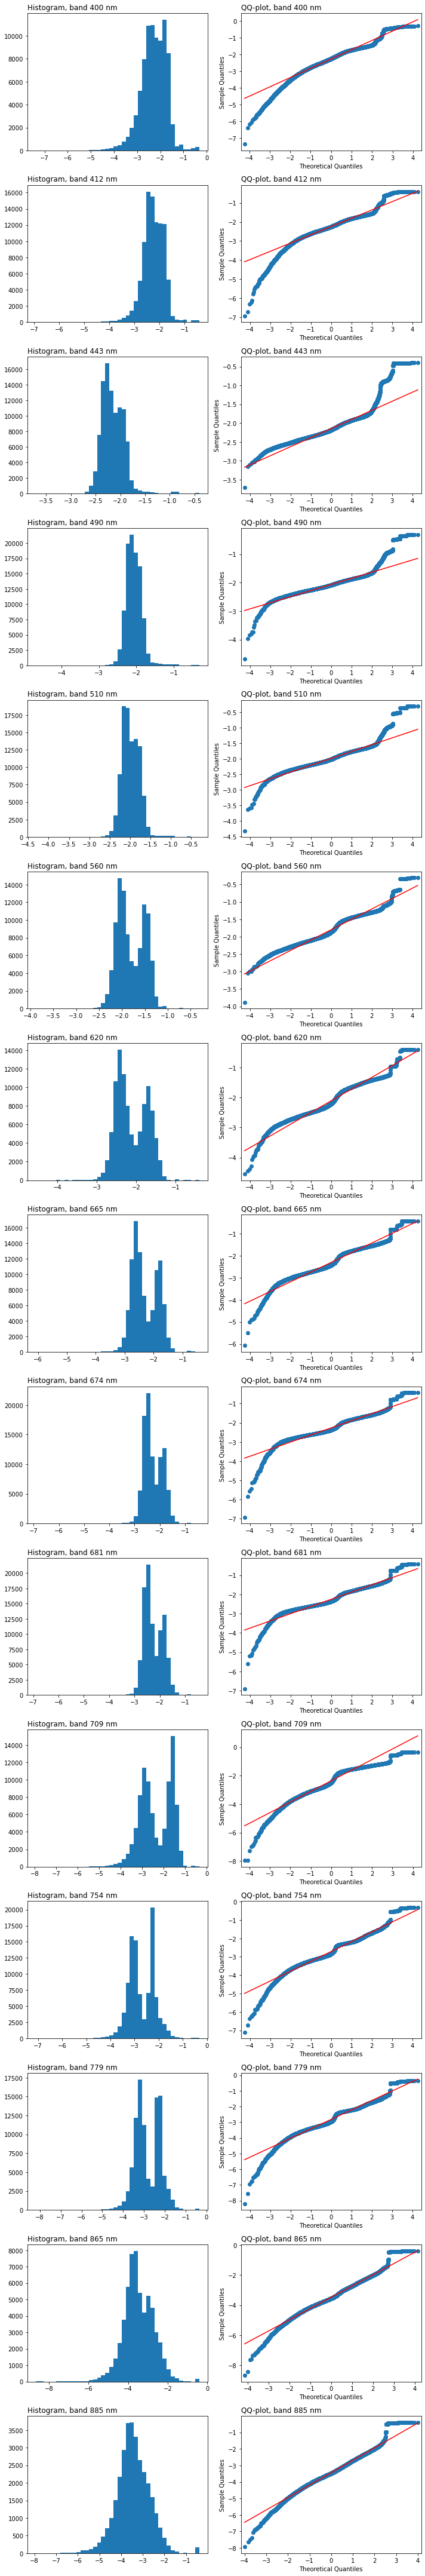

In [51]:
# check log normal distribution assumption
print('Per band Rw log10 normal plots on log transformed training data (negative values removed)')
fig, axs = plt.subplots(15, 2, figsize=(10, 60), tight_layout=True)
for n,band in enumerate(samples.columns):
    da=samples.iloc[:,n]
    da=da[da>0]
    da=np.log10(da)
    da=np.msort(da)
    axs[n,0].hist(da, bins=40)
    axs[n,0].set_title(f"Histogram, band {band} nm", loc='left')
    qqplot(da, line='s', ax=axs[n,1])
    axs[n,1].set_title(f"QQ-plot, band {band} nm", loc='left')

We then check that transformations are properly scaling spectra magnitude differences, without large loss of spectral shape variability captured by the training data. 

Distribution of training data spectra, showing sample mean (solid red line), +/- 1 standard deviation (grey shading), and percentile distribution of all spectra (broken lines, rainbow coloured, see legend for percent). Left plot is for untransformed data, middle plot for straight log-transform data (thus losing a sizeable portion of the data), right plot shows log-transform of additive shifted data. The rightmost plot shows more even distribution around the mean and median after both transformations.

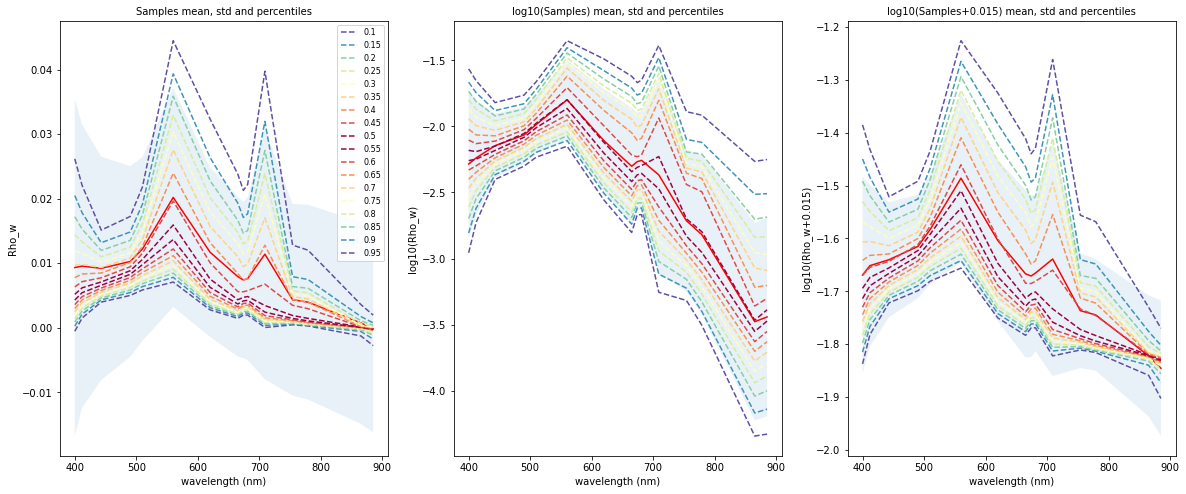

In [53]:
colors = hv.plotting.util.process_cmap('Spectral', 9)
colors = colors[::-1]+colors

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, axes=plt.subplots(1,3,figsize=(20,8))
    ax=axes.flatten()[0]
    ax.fill_between(samples.keys().astype(int), samples.mean(axis=0)-samples.std(axis=0), samples.mean(axis=0)+samples.std(axis=0), alpha=0.1)
    ax.plot(samples.keys().astype(int), samples.mean(axis=0), c='r')
    for i, perc in enumerate(np.arange(0.1,1.0,0.05)):
        ax.plot(samples.keys().astype(int), np.percentile(samples, 100*perc, axis=0), linestyle='dashed', label=np.round(perc,2), color=colors[i])
    ax.legend(fontsize=8)
    ax.set_title('Samples mean, std and percentiles', fontsize=10)
    ax.set_xlabel("wavelength (nm)")
    ax.set_ylabel("Rho_w")
    ax=axes.flatten()[1]
    ax.fill_between(samples.keys().astype(int), np.ma.masked_invalid(np.log10(samples)).mean(axis=0)-np.ma.masked_invalid(np.log10(samples)).std(axis=0), np.ma.masked_invalid(np.log10(samples)).mean(axis=0)+np.ma.masked_invalid(np.log10(samples)).std(axis=0), alpha=0.1)
    ax.plot(samples.keys().astype(int), np.ma.masked_invalid(np.log10(samples)).mean(axis=0), c='r')
    for i, perc in enumerate(np.arange(0.1,1.0,0.05)):
        ax.plot(samples.keys().astype(int), np.nanpercentile(np.log10(samples), 100*perc, axis=0), linestyle='dashed', label=np.round(perc,2), color=colors[i])
#     ax.legend(fontsize=8)
    ax.set_title('log10(Samples) mean, std and percentiles', fontsize=10)
    ax.set_xlabel("wavelength (nm)")
    ax.set_ylabel("log10(Rho_w)")
    ax=axes.flatten()[2]
    ax.fill_between(samples.keys().astype(int), np.ma.masked_invalid(np.log10(samples+shift)).mean(axis=0)-np.ma.masked_invalid(np.log10(samples+shift)).std(axis=0), np.ma.masked_invalid(np.log10(samples+shift)).mean(axis=0)+np.ma.masked_invalid(np.log10(samples+shift)).std(axis=0), alpha=0.1)
    ax.plot(samples.keys().astype(int), np.ma.masked_invalid(np.log10(samples+shift)).mean(axis=0), c='r')
    for i, perc in enumerate(np.arange(0.1,1.0,0.05)):
        ax.plot(samples.keys().astype(int), np.nanpercentile(np.log10(samples+shift), 100*perc, axis=0), linestyle='dashed', label=np.round(perc,2), color=colors[i])
#     ax.legend(fontsize=8)
    ax.set_title(f'log10(Samples+{shift}) mean, std and percentiles', fontsize=10)
    ax.set_xlabel("wavelength (nm)")
    ax.set_ylabel(f"log10(Rho_w+{shift})")

## 2. Fuzzy classification 

### 2.1 Define model parameters



In [61]:
import os, sys
cwd_path = os.getcwd()
fwc_path = cwd_path[0:cwd_path.rfind("/")]
sys.path.append(fwc_path)
import fuzzy_water_clustering as fwc
import fuzzy_water_clustering.sample_netcdf as sampling

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, make_scorer, silhouette_score
from sklearn.metrics.cluster import calinski_harabasz_score, davies_bouldin_score, silhouette_samples, silhouette_score
import sklearn.pipeline as pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config

In [57]:
# create functions for transformations based on analyses above
# shift = 0.015 from above

def negative_adjust(x):
    return np.log10(x+0.015, dtype='float32')

def negative_adjust_inverse(x):
    return (10**x)-0.015

transforms = FunctionTransformer(negative_adjust, inverse_func=negative_adjust_inverse)
transforms

FunctionTransformer(func=<function negative_adjust at 0x7f217c7c6700>,
                    inverse_func=<function negative_adjust_inverse at 0x7f2183508f70>)

In [62]:
pl = pipeline.make_pipeline(
    transforms,
    PCA(),
    fwc.CmeansModel()     
)

In [73]:
cluster_paramgrid = {
    'cmeansmodel__n_clusters': list(np.arange(6,12,1)),
#    'cmeansmodel__n_clusters': list(np.arange(6,8,1)),
    'cmeansmodel__m': list(np.arange(1.5,2.2,0.3))
}

In [64]:
scoring = {
    'XB' : fwc.cluster_scoring.xie_beni,
    'SIL': fwc.cluster_scoring.hard_silouette,
    'FPC': fwc.cluster_scoring.fuzzy_partition_coef,
    'DB' : fwc.cluster_scoring.davies_bouldin,
}

### 2.2 Run gridsearch to identify best model

First perform operations to remove NaNs and unusually high reflectance values

In [66]:
samples_orig = samples
samples = samples.drop(samples[np.isnan(transforms.transform(samples)).any(axis=1)].index)
print(f'Cleaning input samples with transformation, n reduced from {len(samples_orig)} to {len(samples)}')
samples

Cleaning input samples with transformation, n reduced from 98479 to 98479


400       412       443       490       510       560       620  \
0      0.023530  0.019728  0.012376  0.016155  0.022873  0.051459  0.034511   
1      0.006053  0.007931  0.010238  0.011270  0.012659  0.018133  0.005843   
2      0.004672  0.005603  0.006207  0.008114  0.009371  0.011813  0.004722   
3      0.007548  0.009193  0.007935  0.009069  0.009479  0.009612  0.002398   
4      0.001264  0.003000  0.005062  0.006881  0.007425  0.009551  0.003916   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.003940  0.006028  0.007448  0.009441  0.011318  0.014464  0.006071   
99996  0.000854  0.001821  0.003437  0.004304  0.005114  0.006025  0.002184   
99997  0.005037  0.005746  0.005939  0.008130  0.009653  0.017439  0.013926   
99998  0.018886  0.018937  0.012623  0.010667  0.011442  0.029726  0.009995   
99999  0.020202  0.016881  0.012270  0.013400  0.017730  0.036885  0.021047   

            665       674       681       709       754       779       865  \
0      0.027195  0.023258  0.024551  0.053249  0.013031  0.013948  0.002587   
1      0.002309  0.002061  0.001798  0.000616  0.002462  0.001592 -0.001277   
2      0.003105  0.003301  0.003310  0.001861  0.000865  0.000561  0.000089   
3      0.001188  0.001088  0.001114 -0.000141  0.001161  0.000563 -0.000547   
4      0.002481  0.003252  0.003481  0.001201  0.000772  0.000464  0.000064   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.003250  0.004000  0.003793  0.000593  0.001330  0.000824 -0.000055   
99996  0.002195  0.002293  0.002557 -0.000687  0.000360  0.000157  0.000124   
99997  0.008927  0.008401  0.008453  0.011343  0.003368  0.002804  0.000565   
99998  0.005361  0.003458  0.003858  0.026539  0.005565  0.004944 -0.003903   
99999  0.016419  0.013775  0.013766  0.027022  0.005039  0.005369  0.000091   

            885  
0      0.000257  
1     -0.002095  
2     -0.000125  
3     -0.001062  
4      0.000112  
...         ...  
99995 -0.000801  
99996  0.000234  
99997  0.000008  
99998 -0.005517  
99999 -0.001078  

[98479 rows x 15 columns]

In [67]:
# remove training data with reflectances over 0.2
for n,band in enumerate(samples.columns):
    if n == 0:
        exclude = np.full(len(samples[band]), False)
        exclude[np.where(samples[band] > 0.2)[0]] = True
    else:
        exclude_temp = np.full(len(samples[band]), False)
        exclude_temp[np.where(samples[band] > 0.2)[0]] = True
        exclude = exclude | exclude_temp

nan_n = len(samples)
samples = samples.iloc[~exclude, :]
print(f'Cleaning input samples with high reflectance, n further reduced from {nan_n} to {len(samples)}')
samples

Cleaning input samples with high reflectance, n further reduced from 98479 to 97988


400       412       443       490       510       560       620  \
0      0.023530  0.019728  0.012376  0.016155  0.022873  0.051459  0.034511   
1      0.006053  0.007931  0.010238  0.011270  0.012659  0.018133  0.005843   
2      0.004672  0.005603  0.006207  0.008114  0.009371  0.011813  0.004722   
3      0.007548  0.009193  0.007935  0.009069  0.009479  0.009612  0.002398   
4      0.001264  0.003000  0.005062  0.006881  0.007425  0.009551  0.003916   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.003940  0.006028  0.007448  0.009441  0.011318  0.014464  0.006071   
99996  0.000854  0.001821  0.003437  0.004304  0.005114  0.006025  0.002184   
99997  0.005037  0.005746  0.005939  0.008130  0.009653  0.017439  0.013926   
99998  0.018886  0.018937  0.012623  0.010667  0.011442  0.029726  0.009995   
99999  0.020202  0.016881  0.012270  0.013400  0.017730  0.036885  0.021047   

            665       674       681       709       754       779       865  \
0      0.027195  0.023258  0.024551  0.053249  0.013031  0.013948  0.002587   
1      0.002309  0.002061  0.001798  0.000616  0.002462  0.001592 -0.001277   
2      0.003105  0.003301  0.003310  0.001861  0.000865  0.000561  0.000089   
3      0.001188  0.001088  0.001114 -0.000141  0.001161  0.000563 -0.000547   
4      0.002481  0.003252  0.003481  0.001201  0.000772  0.000464  0.000064   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.003250  0.004000  0.003793  0.000593  0.001330  0.000824 -0.000055   
99996  0.002195  0.002293  0.002557 -0.000687  0.000360  0.000157  0.000124   
99997  0.008927  0.008401  0.008453  0.011343  0.003368  0.002804  0.000565   
99998  0.005361  0.003458  0.003858  0.026539  0.005565  0.004944 -0.003903   
99999  0.016419  0.013775  0.013766  0.027022  0.005039  0.005369  0.000091   

            885  
0      0.000257  
1     -0.002095  
2     -0.000125  
3     -0.001062  
4      0.000112  
...         ...  
99995 -0.000801  
99996  0.000234  
99997  0.000008  
99998 -0.005517  
99999 -0.001078  

[97988 rows x 15 columns]

Run the estimator to find the best model

**Warning** this takes a long, please be patient. If you have lots of CPU cores the `n_jobs` parameter can be increased

In [ ]:
gs_clusters = GridSearchCV(
    pl,
    param_grid=cluster_paramgrid,
    scoring=scoring,
    refit='XB',
    n_jobs=6, 
    verbose=4
)
gs_clusters.fit(samples)
print(gs_clusters.best_estimator_['cmeansmodel'])

final_pipeline = gs_clusters.best_estimator_
final_pipeline